In [75]:
import math
import numpy as np
from torch import cos, sin
import scipy.optimize as opt
import torch
import torch.nn as nn
%matplotlib ipympl
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA

import warnings
warnings.filterwarnings('ignore')

import sys
sys.path.append("../../../ddn/")
from ddn.pytorch.node import *

from pytorch3d.loss import chamfer_distance
from pytorch3d.ops import sample_farthest_points
import alphashape
from descartes import PolygonPatch
import pytorch3d

from pytorch3d.io import IO, load_obj, save_obj,load_objs_as_meshes
from pytorch3d.structures import join_meshes_as_scene, Meshes, Pointclouds

from pytorch3d.loss import (
    chamfer_distance, 
    mesh_edge_loss, 
    mesh_laplacian_smoothing, 
    mesh_normal_consistency,
)

In [76]:
import faulthandler
faulthandler.enable()


In [77]:
if torch.cuda.is_available():
    device = torch.device("cuda")
else:
    device = torch.device("cpu")
print(f"Using device: {device}")

Using device: cpu


In [78]:
def get_signed_tet_volume(face_vertices: torch.Tensor) -> torch.Tensor:
    """
    Compute signed tetrahedron volumes for a batch of faces.

    Args:
        face_vertices (torch.Tensor): Tensor of shape (F, 3, 3), where
                                      F is the number of faces, and each face
                                      consists of 3 vertices in 3D.

    Returns:
        torch.Tensor: A tensor of shape (F,) containing signed volumes.
    """
    v0, v1, v2 = face_vertices[:, 0, :], face_vertices[:, 1, :], face_vertices[:, 2, :]
    
    # Compute determinant of the 3x3 matrix [v0, v1, v2]
    volumes = torch.det(torch.stack([v0, v1, v2], dim=-1)) / 6.0  # Shape: (F,)

    return volumes

def get_volume_batch(meshes: Meshes):
    verts_packed = meshes.verts_packed()  # (sum(V_i), 3)
    faces_packed = meshes.faces_packed()  # (sum(F_i), 3)
    mesh_to_face = meshes.mesh_to_faces_packed_first_idx()  # Index of first face per mesh
    n_meshes = len(meshes)
    volumes = torch.zeros(n_meshes, device=verts_packed.device)

    for i in range(n_meshes):
        start = mesh_to_face[i]
        end = start + meshes.num_faces_per_mesh()[i]
        face_vertices = verts_packed[faces_packed[start:end]]  # (F, 3, 3)
        volumes[i] = get_signed_tet_volume(face_vertices).sum()  # Sum over all faces

    return volumes.abs()  # Returns a tensor of shape (num_meshes,)

In [79]:
init_mesh = load_objs_as_meshes(["../../../Blender/sphere_2.obj"])
init_vol = get_volume_batch(init_mesh)[0].item()
init_mesh.verts_list()[0].size()

torch.Size([162, 3])

In [82]:
base = "../../../Blender/"
import os 
# shapes = ["balloon", "rstrawberry", "sphere", "parabola"]
shapes = ["balloon"] * 4
obj_paths = []
for s in shapes:
    obj_paths.append(os.path.join(base, s+"_2.obj"))

balloon, strawberry, sphere, parabola = load_objs_as_meshes(obj_paths)
print(get_volume_batch(load_objs_as_meshes(obj_paths)))

tensor([4.2485, 4.2485, 4.2485, 4.2485])


In [83]:
def least_squares(u0, target):
    """
    u0 are vertices
    """
    if not torch.is_tensor(u0):
        u0 = torch.tensor(u0)
    if not torch.is_tensor(target):
        target = torch.tensor(target)

    res = torch.square(u0 - target).sum()
    print("lstsq", res)
    return res.double()

def least_squares_grad(u0, target):
    if torch.is_tensor(u0):
        u0 = u0.detach().clone()
    else:
        u0 = torch.tensor(u0)
        
    if torch.is_tensor(target):
        target = target.detach().clone()
    else:
        target = torch.tensor(target)
        
    # Ensure that u0 requires gradients
    u0.requires_grad = True
    
    with torch.enable_grad():
        res = torch.square(u0 - target).sum()

    # Compute the gradient
    obj_grad = torch.autograd.grad(res, u0)[0]
    print("obj_grad", obj_grad)
    return obj_grad.double()

def get_volume(u, faces, init_vol):
    if not torch.is_tensor(u):
        u = torch.tensor(u)
    if not torch.is_tensor(faces):
        faces = torch.tensor(faces)
    if not torch.is_tensor(init_vol):
        init_vol = torch.tensor(init_vol)
    
    vertices = u.view(-1,3)
    face_vertices = vertices[faces]  # (F, 3, 3)
    volume = get_signed_tet_volume(face_vertices).sum()
    res = volume.abs() - init_vol
    print("vol", res)
    return res.double()

def get_volume_grad(u, faces, init_vol):
    if not torch.is_tensor(u):
        u = torch.tensor(u, dtype=torch.float64, requires_grad=True)
    else:
        u = u.clone().detach().requires_grad_(True)
    
    if not torch.is_tensor(faces):
        faces = torch.tensor(faces, dtype=torch.long)
    
    if not torch.is_tensor(init_vol):
        init_vol = torch.tensor(init_vol, dtype=torch.float64)
    
    with torch.enable_grad():
        vertices = u.view(-1, 3)
        face_vertices = vertices[faces]  # (F, 3, 3)
        volume = get_signed_tet_volume(face_vertices).sum()
        res = volume.abs() - init_vol
    
    volume_grad = torch.autograd.grad(res, u, retain_graph=True)[0]
    print("volume grad", volume_grad)
    
    return volume_grad.double()


In [89]:
def project(meshes: Meshes, targets: Meshes):
    n_batches = len(meshes)
    n_vtxs = len(meshes[0].verts_packed())
    results = torch.zeros(n_batches, n_vtxs, 3, dtype=torch.double)
    losses = torch.zeros(n_batches, 1, dtype=torch.double)
    for batch_number, mesh in enumerate(meshes):
        init_vol = get_volume_batch(mesh).double().detach().cpu().numpy()
        print("batch number", batch_number)
        vertices = mesh.verts_packed().flatten().detach().numpy().astype(np.float64)
        faces = mesh.faces_packed().detach().numpy().astype(np.int64)
        target_vtx = targets[batch_number].verts_packed().flatten().detach().numpy().astype(np.float64)
        eq_const = {
            'type': 'eq',
            'fun' : lambda u: get_volume(u, faces, init_vol).cpu().numpy().astype(np.float64),
            'jac' : lambda u: get_volume_grad(u, faces, init_vol).cpu().numpy().astype(np.float64)
        }
        print("starting optimisation")
        res = opt.minimize(
            lambda u: least_squares(u, target_vtx).detach().cpu().numpy().astype(np.float64),
            vertices, 
            jac=lambda u: least_squares_grad(u, target_vtx).cpu().numpy().astype(np.float64),
            method='SLSQP', 
            constraints=[eq_const],
            options={'ftol': 1e-4, 'disp': True, 'maxiter': 100}
        )   
        print("finished")
        if not res.success:
            print("FIT failed:", res.message)
        results[batch_number] = torch.tensor(res.x, dtype=torch.double, requires_grad=True).view(-1,3)
        losses[batch_number] = torch.tensor(res.fun, dtype=torch.double, requires_grad=False)
    return results, losses


In [90]:
project(init_mesh, balloon)


batch number 0
starting optimisation
vol tensor([-3.2656e-07], dtype=torch.float64)
lstsq tensor(3.0159, dtype=torch.float64)
obj_grad tensor([ 1.9305e-01,  2.7035e-01,  0.0000e+00, -1.9305e-01,  1.2752e-02,
         0.0000e+00,  1.9305e-01, -2.7035e-01,  0.0000e+00, -1.9305e-01,
        -1.2752e-02,  0.0000e+00,  0.0000e+00, -8.7482e-02, -1.4155e-01,
         0.0000e+00,  8.7482e-02, -1.4155e-01,  0.0000e+00, -8.7482e-02,
         1.4155e-01,  0.0000e+00,  8.7482e-02,  1.4155e-01, -3.1237e-01,
         0.0000e+00, -4.1314e-02, -3.1237e-01,  0.0000e+00,  4.1314e-02,
         3.1237e-01,  0.0000e+00,  2.1628e-01,  3.1237e-01,  0.0000e+00,
        -2.1628e-01,  2.9708e-01,  1.9970e-01, -1.2342e-01,  1.8360e-01,
         9.5920e-02, -2.5112e-01,  1.1347e-01,  2.0662e-01, -1.2770e-01,
        -1.1347e-01,  6.2622e-02, -3.8702e-02,  0.0000e+00,  1.6640e-01,
         0.0000e+00, -1.1347e-01,  6.2622e-02,  3.8702e-02,  1.1347e-01,
         2.0662e-01,  1.2770e-01,  1.8360e-01,  9.5920e-02,  2

(tensor([[[-6.3087e-01,  7.2899e-01, -5.4714e-18],
          [ 6.3071e-01,  8.5870e-01, -1.0338e-16],
          [-6.3087e-01, -7.2899e-01, -1.0895e-15],
          [ 6.3071e-01, -8.5870e-01, -2.5399e-16],
          [-4.7571e-04, -4.9063e-01, -7.9385e-01],
          [-4.7571e-04,  4.9063e-01, -7.9385e-01],
          [-4.7571e-04, -4.9063e-01,  7.9385e-01],
          [-4.7571e-04,  4.9063e-01,  7.9385e-01],
          [ 1.0213e+00,  3.0907e-12,  5.5548e-01],
          [ 1.0213e+00,  3.0903e-12, -5.5548e-01],
          [-1.0201e+00,  2.4030e-12,  4.2577e-01],
          [-1.0201e+00,  2.4031e-12, -4.2577e-01],
          [-9.7000e-01,  4.0792e-01, -2.5211e-01],
          [-5.9997e-01,  2.6597e-01, -6.9632e-01],
          [-3.7113e-01,  7.1876e-01, -4.4421e-01],
          [ 3.7027e-01,  7.9135e-01, -4.8908e-01],
          [-6.1319e-04,  9.3330e-01,  1.5688e-16],
          [ 3.7027e-01,  7.9135e-01,  4.8908e-01],
          [-3.7113e-01,  7.1876e-01,  4.4421e-01],
          [-5.9997e-01,  2.6597

In [74]:
torch.autograd.set_detect_anomaly(True)

def least_squares(u0, tgt_vtxs):
    """
    u0 are vertices
    """
    if not torch.is_tensor(x):
        x = torch.tensor(x)
    if not torch.is_tensor(tgt_vtxs):
        tgt_vtxs = torch.tensor(tgt_vtxs)

    res = torch.square(x - tgt_vtxs).sum()
    return res.double()

def least_squares_grad(u0, tgt_vtxs):
    if torch.is_tensor(u0):
        u0 = u0.detach().clone()
    else:
        u0 = torch.tensor(u0)
    if torch.is_tensor(tgt_vtxs):
        tgt_vtxs = tgt_vtxs.detach().clone()
    else:
        tgt_vtxs = torch.tensor(tgt_vtxs)
        
    # Ensure that u0 requires gradients
    gradient = 2 * (u0 - tgt_vtxs)
    return gradient.double()


def calculate_volume(vertices, faces):
    face_vertices = vertices[faces]  # (F, 3, 3)
    v0, v1, v2 = face_vertices[:, 0, :], face_vertices[:, 1, :], face_vertices[:, 2, :]
    
    # Compute determinant of the 3x3 matrix [v0, v1, v2]
    face_volumes = torch.det(torch.stack([v0, v1, v2], dim=-1)) / 6.0  # Shape: (F,)
    volume = face_volumes.sum()
    return volume.abs()


def volume_constraint(x, faces, tgt_vol):
    """
    Calculate the volume of a mesh using PyTorch tensors.
    Args:
        vertices_torch: Nx3 tensor of vertex coordinates
        faces: Mx3 array of face indices
    Returns:
        volume: Total volume of the mesh as a PyTorch scalar
    """
    if not torch.is_tensor(x):
        x = torch.tensor(x)
    if not torch.is_tensor(faces):
        faces = torch.tensor(faces)
    if not torch.is_tensor(tgt_vol):
        tgt_vol = torch.tensor(tgt_vol)

    vertices = x.view(-1,3)
    faces = faces.view(-1,3)    
    volume = calculate_volume(vertices, faces)
    res = volume.abs() - tgt_vol
    return res.double()

def volume_constraint_grad(x, faces):
    if torch.is_tensor(x):
        x = x.detach().clone()
    else:
        x = torch.tensor(x)
    if torch.is_tensor(faces):
        faces = faces.detach().clone()
    else:
        faces = torch.tensor(faces)

    vertices_torch = x.view(-1, 3)
    p0 = vertices_torch[faces[:, 0]]  # (F, 3)
    p1 = vertices_torch[faces[:, 1]]  # (F, 3)
    p2 = vertices_torch[faces[:, 2]]  # (F, 3)

    grad_p0 = torch.cross(p1, p2, dim=1) / 6.0
    grad_p1 = torch.cross(p2, p0, dim=1) / 6.0
    grad_p2 = torch.cross(p0, p1, dim=1) / 6.0

    grad_verts = torch.zeros_like(vertices_torch)
    grad_verts.scatter_add_(0, faces[:, 0].unsqueeze(1).expand(-1, 3), grad_p0)
    grad_verts.scatter_add_(0, faces[:, 1].unsqueeze(1).expand(-1, 3), grad_p1)
    grad_verts.scatter_add_(0, faces[:, 2].unsqueeze(1).expand(-1, 3), grad_p2)

    analytical_grad = grad_verts.flatten()
    return analytical_grad 


class ConstrainedProjectionNode(EqConstDeclarativeNode):

    def __init__(self, src: Meshes, tgt: Meshes):
        super().__init__(eps=1.0e-6) # relax tolerance on optimality test 
        self.src = src # source meshes (B,)
        self.tgt = tgt # target meshes (B,)

    def objective(self, xs: torch.Tensor, y: torch.Tensor, scatter_add=True):
        """
        Calculates sum of squared differences between source and target meshes.

        Args:
            xs (tensor): vertices of original mesh, sum(V_i) x 3
            y (tensor): vertices of projected mesh, sum(V_i) x 3
        """
        src_verts = y.view(-1,3) # (sum(V_i), 3)
        tgt_verts = self.tgt.verts_packed().detach() # (sum(V_i), 3)
        sqr_diffs = torch.square(src_verts - tgt_verts) # (sum(V_i), 3)

        n_batches = len(self.src)
        sse = torch.zeros(n_batches, dtype=sqr_diffs.dtype)
        if scatter_add:
            sse.scatter_add_(0, self.src.verts_packed_to_mesh_idx(), sqr_diffs)
        else:
            n_verts_per_mesh = self.src.num_verts_per_mesh()
            for i in range(n_batches):
                mesh_to_vert = self.src.mesh_to_verts_packed_first_idx()  # Index of first face per mesh
                start = mesh_to_vert[i]
                end = start + n_verts_per_mesh[i]
                sse[i] = sqr_diffs[start:end].sum()  # Sum over all faces
        return sse

    def equality_constraints(self, xs, y, scatter_add=True):
        """
        Enforces volume constraint
        Assumes same number of vertices in each projected mesh currently

        Args:
            xs (tensor): vertices of original mesh, sum(V_i) x 3
            y (tensor): vertices of projected mesh, sum(V_i) x 3
        """
        n_batches = len(self.src)
        verts_packed = y.view(-1,3) # (sum(V_i), 3)

        faces_packed = self.src.faces_packed()  # (sum(F_i), 3)
        face_vertices = verts_packed[faces_packed]  # (sum(F_i), 3, 3)
        
        # Calculate tetrahedron volumes for each face
        v0, v1, v2 = face_vertices[:, 0, :], face_vertices[:, 1, :], face_vertices[:, 2, :]
        cross_product = torch.cross(v0, v1, dim=-1)  # (F, 3)
        face_volumes = torch.sum(cross_product * v2, dim=-1) / 6.0  # (F,)
        volumes = torch.zeros(n_batches, device=verts_packed.device, dtype=face_volumes.
                                dtype)
        if scatter_add:
            volumes.scatter_add_(0, self.src.faces_packed_to_mesh_idx(), face_volumes)
        else:
            n_faces_per_mesh = self.src.num_faces_per_mesh()
            for i in range(n_batches):
                mesh_to_face = self.src.mesh_to_faces_packed_first_idx()  # Index of first face per mesh
                start = mesh_to_face[i]
                end = start + n_faces_per_mesh[i]
                volumes[i] = face_volumes[start:end].sum()  # Sum over all faces

        volumes = volumes.abs()
        return volumes  # Shape: (B,)    
    
    def solve(self, xs: torch.Tensor):
        n_batches = len(self.src)
        start_vtx = self.src.mesh_to_verts_packed_first_idx()
        end_vtx = start_vtx + self.src.num_verts_per_mesh()
        
        n_vtx = len(self.src.verts_packed())
        results = torch.zeros(n_vtx, 3, dtype=torch.double)
        for batch in range(n_batches):
            start,end = start_vtx[batch],end_vtx[batch]
            verts = xs[start:end].flatten().detach().double().cpu().numpy()
            faces = self.src[batch].faces_packed().detach().double().cpu().numpy()
            tgt_vtx = self.tgt[batch].verts_packed().detach()
            tgt_faces = self.tgt[batch].faces_packed().detach()
            with torch.no_grad():
                tgt_vol = volume_constraint(tgt_vtx, tgt_faces)

            eq_constraint = {
                'type': 'eq',
                'fun' : lambda u: volume_constraint(u, faces, tgt_vol).cpu().numpy(),
                'jac' : lambda u: volume_constraint_grad(u, faces).cpu().numpy()
            }

            res = opt.minimize(
                lambda u: least_squares(u, tgt_vtx),
                verts,
                method='SLSQP',
                jac=lambda u: least_squares_grad(u, tgt_vtx),
                constraints=[eq_constraint],
                options={'ftol': 1e-6, 'iprint': 2, 'maxiter': 100}
            )

            if not res.success:
                print("FAILED:", res.message)
            results[start:end, :] = torch.tensor(res.x, dtype=torch.double, requires_grad=True).view(-1,3)
        return results,None

In [39]:
def read_matrices_from_file(filename):
    matrices = {}
    current_cam = None
    
    with open(filename, "r") as f:
        lines = f.readlines()
        
    i = 0
    while i < len(lines):
        line = lines[i].strip()
        
        if line.startswith("Camera:"):
            current_cam = line.split("Camera: ")[1]
            matrices[current_cam] = {}
        elif any(matrix_type in line for matrix_type in ["K (Intrinsic", "RT (Extrinsic", "P (Projection"]):
            matrix_type = line.split(" ")[0]  
            i += 1
            matrices[current_cam][matrix_type] = torch.tensor(np.loadtxt(lines[i:i+3]), dtype=torch.float32)
            i += 2  
        i += 1
        
    return matrices

filename = "../../../Blender/camera_matrices.txt"
matrices = read_matrices_from_file(filename)

for cam, data in matrices.items():
    print(f"Camera: {cam}")
    for key, matrix in data.items():
        print(f"{key}:\n{matrix}\n")

Camera: Camera
K:
tensor([[2.6667e+03, 0.0000e+00, 9.6000e+02],
        [0.0000e+00, 2.6667e+03, 5.4000e+02],
        [0.0000e+00, 0.0000e+00, 1.0000e+00]])

RT:
tensor([[ 6.8592e-01,  7.2768e-01, -4.0113e-09, -7.8816e-03],
        [ 3.2401e-01, -3.0542e-01, -8.9540e-01, -6.0012e-02],
        [-6.5156e-01,  6.1417e-01, -4.4527e-01,  1.1256e+01]])

P:
tensor([[ 1.2036e+03,  2.5301e+03, -4.2746e+02,  1.0785e+04],
        [ 5.1219e+02, -4.8280e+02, -2.6282e+03,  5.9183e+03],
        [-6.5156e-01,  6.1417e-01, -4.4527e-01,  1.1256e+01]])

Camera: Camera.001
K:
tensor([[2.6667e+03, 0.0000e+00, 9.6000e+02],
        [0.0000e+00, 2.6667e+03, 5.4000e+02],
        [0.0000e+00, 0.0000e+00, 1.0000e+00]])

RT:
tensor([[-1.0000e+00,  8.7423e-08,  0.0000e+00, -8.7423e-07],
        [ 0.0000e+00, -3.4229e-08, -1.0000e+00,  3.4229e-07],
        [-8.7423e-08, -1.0000e+00, -3.4229e-08,  1.0000e+01]])

P:
tensor([[-2.6667e+03, -9.6000e+02, -3.2859e-05,  9.6000e+03],
        [-4.7208e-05, -5.4000e+02, -2.66

In [57]:
import torch
import numpy as np
import matplotlib.pyplot as plt

def project_vertices(vertices, projection_matrix):
    ones = torch.ones((vertices.shape[0], 1), dtype=vertices.dtype, device=vertices.device)
    vertices_homogeneous = torch.cat([vertices, ones], dim=1)  
    
    projected = projection_matrix @ vertices_homogeneous.T  
    
    projected = projected.T  # Shape becomes Nx3
    projected_cartesian = projected[:, :2] / projected[:, 2:3] 
    
    return projected_cartesian


P = matrices["Camera"]["P"]  # Shape is 3x4
vertices = parabola.verts_packed()  # Shape is Nx3
points_2d = project_vertices(vertices, P)

# plt.figure(figsize=(9.6, 5.4)) 
# plt.scatter(points_2d[:, 0], points_2d[:, 1], s=1, c='blue', alpha=0.5)
# plt.xlim(0, 1920)
# plt.ylim(0, 1080)
# plt.gca().invert_yaxis()  # Invert y-axis to match image coordinates (0 at top)

# plt.title('Projected Vertices')
# plt.xlabel('X (pixels)')
# plt.ylabel('Y (pixels)')
# plt.grid(True, alpha=0.3)

# plt.tight_layout()
# plt.savefig('projected_vertices.png', dpi=100)
# plt.show()

In [58]:
from alpha_shapes import Alpha_Shaper, plot_alpha_shape


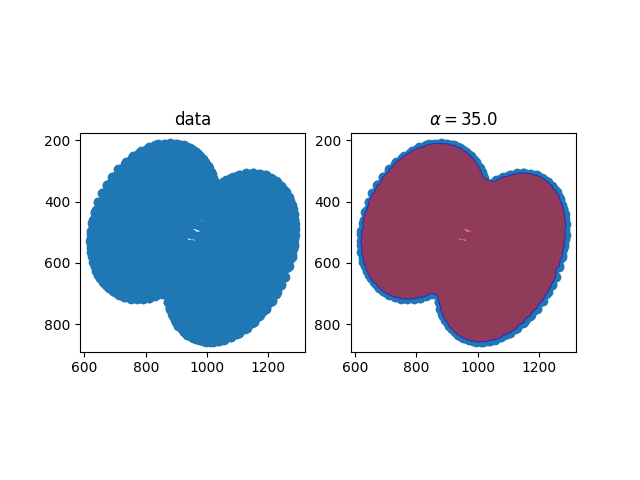

In [60]:
alpha = 25.0
shaper = Alpha_Shaper(points_2d)
# alpha_opt, alpha_shape = shaper.optimize()
alpha_shape = shaper.get_shape(alpha=alpha)
# print(alpha_shape.boundary)
fig, (ax0, ax1) = plt.subplots(1, 2)
ax0.scatter(*zip(*points_2d))
ax0.set_title('data')
ax1.scatter(*zip(*points_2d))
ax0.invert_yaxis()
ax1.invert_yaxis()
plot_alpha_shape(ax1, alpha_shape)
ax1.set_title(f"$\\alpha={alpha:.3}$")

for ax in (ax0, ax1):
    ax.set_aspect('equal')

for v in points_2d:
    if tuple(v) == (418.04653482558206, 462.9141846233106):
        print(v)

In [9]:
foo = load_obj("../../../Blender/sphere_3.obj")
foo[0].size()

torch.Size([642, 3])

AttributeError: 'tuple' object has no attribute 'verts_packed'

In [73]:
import torch
from pytorch3d.structures import Meshes

# Define vertices and faces for cube
verts_cube = torch.tensor([
    [-0.5, -0.5, -0.5],  # 0
    [ 0.5, -0.5, -0.5],  # 1
    [ 0.5,  0.5, -0.5],  # 2
    [-0.5,  0.5, -0.5],  # 3
    [-0.5, -0.5,  0.5],  # 4
    [ 0.5, -0.5,  0.5],  # 5
    [ 0.5,  0.5,  0.5],  # 6
    [-0.5,  0.5,  0.5]   # 7
], dtype=torch.float32)

faces_cube = torch.tensor([
    [0, 2, 1], [0, 3, 2],  # Front
    [1, 6, 5], [1, 2, 6],  # Right
    [5, 7, 4], [5, 6, 7],  # Back
    [4, 3, 0], [4, 7, 3],  # Left
    [3, 6, 2], [3, 7, 6],  # Top
    [4, 1, 5], [4, 0, 1]   # Bottom
], dtype=torch.int64)

# Define vertices and faces for tetrahedron
verts_tetra = torch.tensor([
    [0, 0, 1],
    [1, 0, 0],
    [0, 1, 0], 
    [0, 0, 0]], dtype=torch.float32)

faces_tetra = torch.tensor([
    [3, 1, 2],
    [3, 1, 0],
    [3, 0, 2],
    [0, 1, 2]
], dtype=torch.int64)

# Create batched mesh
# mesh = Meshes(verts=[verts_cube, verts_tetra], faces=[faces_cube, faces_tetra])
mesh = Meshes(verts=[verts_tetra, verts_tetra], faces=[faces_tetra, faces_tetra])

# Define test class
class VolumeConstraintTest:
    def __init__(self, mesh):
        self.src = mesh
    
    def equality_constraints(self, xs, y):
        """
        Enforces volume constraint
        Assumes same number of vertices in each projected mesh currently

        Args:
            xs (tensor): vertices of original mesh, B x V x 3
            y (tensor): vertices of projected mesh, B x V x 3
        """
        n_batches = len(xs)
        verts = y  # Already in shape (B, V, 3)

        faces = self.src.faces_padded().view(n_batches, -1, 3)  # (B, F, 3)
        _, n_faces, _ = faces.size()
        batch_indices = torch.arange(n_batches)[:, None, None].expand(-1, n_faces, 3)

        print(faces)

        face_vertices = verts[batch_indices, faces]  # (B, F, 3, 3)
        v0, v1, v2 = face_vertices[:, :, 0, :], face_vertices[:, :, 1, :], face_vertices[:, :, 2, :]
        cross = torch.cross(v1, v2, dim=-1)  # (B, F, 3)
        face_volumes = torch.einsum('bfi,bfi->bf', v0, cross) / 6.0  # (B, F)
        volumes = torch.sum(face_volumes, dim=1).abs()  # (B,)
        return volumes  # (B,)

# Test the volume computation
test = VolumeConstraintTest(mesh)

# Create slightly modified vertices for the "projected" mesh
# This just adds a small offset to each vertex
verts_cube_proj = verts_cube + 0.05  # Small offset
verts_tetra_proj = verts_tetra + 0.05  # Small offset

# Original vertices (batched)
xs = [verts_cube, verts_tetra]

# "Projected" vertices (batched)
y = [verts_cube_proj, verts_tetra_proj]

# Convert to tensors
# xs_tensor = torch.stack([x for x in xs])
# y_tensor = torch.stack([y for y in y])

# Compute volumes

tmp = torch.stack ([xs[0], xs[0]])

volumes = test.equality_constraints(tmp, tmp)

print(f"Computed volumes: {volumes}")
print(f"Shape of volumes: {volumes.shape}")

# Optional: Compute analytical volume for comparison
cube_volume = 1.0  # 1×1×1 cube
tetra_volume = 1/6  # volume of unit tetrahedron

print(f"Expected cube volume: {cube_volume}")
print(f"Expected tetrahedron volume: {tetra_volume}")
print(f"Ratio of computed volumes: {volumes[0]/volumes[1]:.2f}")

tensor([[[3, 1, 2],
         [3, 1, 0],
         [3, 0, 2],
         [0, 1, 2]],

        [[3, 1, 2],
         [3, 1, 0],
         [3, 0, 2],
         [0, 1, 2]]])
Computed volumes: tensor([0.1667, 0.1667])
Shape of volumes: torch.Size([2])
Expected cube volume: 1.0
Expected tetrahedron volume: 0.16666666666666666
Ratio of computed volumes: 1.00
